In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

## Homography

Với một mặt phẳng ảnh, khi thay đổi góc nhìn chụp ảnh mặt phẳng ảnh đó thì luôn tồn tại một ma trận biến đổi $\mathbf{H}$ kích thước $3 \times 3$ thể hiện quan hệ về góc chụp giữa các ảnh.

Đầu vào của bài toán homography là một tập các cặp điểm tương quan $\{ (\mathbf{x}_i, \mathbf{y}_i) \}_{i=1}^N$, với $N$ đủ và có thể có nhiễu, các cặp điểm ngoại lai (outliers). Yêu cầu đầu ra của thuật toán là tìm ra ma trận biến đổi $\mathbf{H}$ và tập các cặp dữ liệu inlier thỏa mãn rằng với các cặp $(\mathbf{x}_i, \mathbf{y}_i)$ nằm trong inlier thì $\mathbf{H}\mathbf{x}_i = \mathbf{y}_i$ trên không gian homogeneous.

Nếu không có dữ liệu ngoại lai (outlier) và nhiễu thì bài toán có thể giải quyết bằng cách giải các hệ phương trình $\mathbf{H}\mathbf{x}_i \times \mathbf{y}_i = 0$ với ẩn là 9 tham số trong ma trận $\mathbf{H}$. Do mỗi hệ $\mathbf{H}\mathbf{x}_i \times \mathbf{y}_i = 0$ cho ra 2 phương trình nên cần tối thiểu $N=4$ để tìm được ma trận $\mathbf{H}$.

Ngược lại trong trường hợp có ngoại lai outlier thì thuật toán xác suất RANSAC sẽ giúp giải quyết bài toán với xác suất rất lớn tìm thành công tập inlier có kích thước đủ lớn. Cụ thể thì RANSAC sẽ chọn ra ngẫu nhiên một tập 4 cặp dữ liệu trong số $N$ cặp dữ liệu, rồi tìm ma trận $\mathbf{H}$ tương ứng và sau đó đếm số lượng các cặp nằm trong inliner thỏa mãn $\mathbf{H}\mathbf{x}_i \times \mathbf{y}_i = 0$ với sai số $\epsilon$ cho trước. Ma trận $\mathbf{H}$ đầu ra sẽ là ma trận có số lượng cặp thuộc inlier lớn nhất với sai số $\epsilon$.

Cuối cùng, thuật toán sẽ sử dụng phương pháp tối ưu Levenberg-Marquardt để tối ưu sai số re-project (không có tính chất tuyến tính).

Trong OpenCV, việc giải quyết bài toán homography có thể được thực hiện thông qua hàm `findHomography` với các tham số có thể truyền vào
* `srcPoints` - tập điểm $\{ \mathbf{x}_i \}_{i=1}^N$
* `dstPoints` - tập điểm $\{ \mathbf{y}_i \}_{i=1}^N$
* `method` - phương pháp giải
    * `0` - giải hệ với giả thiết không có outlier như đã trình bày trên
    * `cv.RANSAC` - sử dụng phương pháp RANSAC

*NOTE: Theo lý thuyết, trước khi giải quyết bài toán homography thì cần phải chuẩn hóa (normalize) tập dữ liệu đầu vào để tăng cường tính ổn định, robust cho thuật toán giải. Tuy nhiên chưa rõ là hàm `findHomography` của OpenCV có thực hiện việc normalize dữ liệu hay không.*

#### ORB

[[ 1.70731289e+00  3.59520602e-01  4.40168482e+02]
 [-5.64789594e-01  1.59689829e+00  1.51860921e+02]
 [-3.02058734e-05 -1.62710643e-04  1.00000000e+00]]


Text(0.5, 1.0, 'Inlier only')

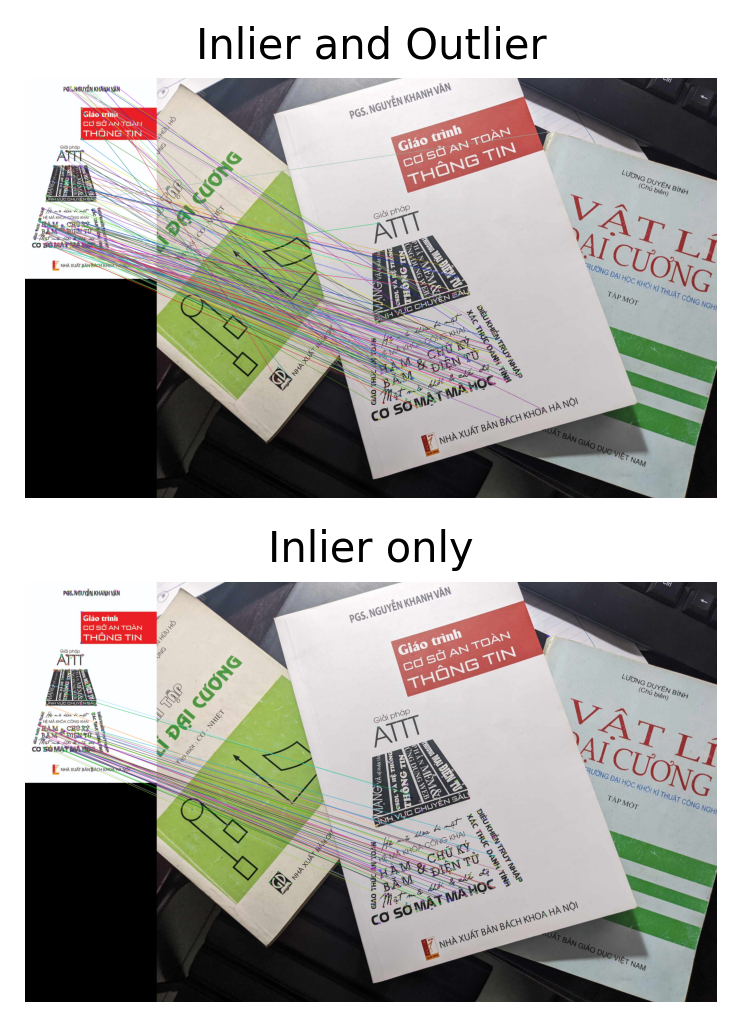

In [2]:
img1 = cv.imread('../images/cover.jpg') # query image
img2 = cv.imread('../images/books.jpg') # train image

orb = cv.ORB_create() # khởi tạo lớp thuật toán ORB
kp1, des1 = orb.detectAndCompute(img1, None) # phát hiện các đặc trưng, keypoints ORB trong query image
kp2, des2 = orb.detectAndCompute(img2, None) # phát hiện các đặc trưng, keypoints ORB trong train image

bf = cv.BFMatcher(normType=cv.NORM_HAMMING, crossCheck=True) # khởi tạo lớp thuật toán ghép cặp với metric Hamming
matches = bf.match(des1, des2) # query descriptor tương ứng với des1, train descriptor tương ứng với des2

# vẽ các ghép cặp giữa hai ảnh
img3 = cv.drawMatches(img1, kp1, img2, kp2, matches, None)

src_pts = np.float32([ kp1[m.queryIdx].pt for m in matches ]) # xác định tập điểm x
dst_pts = np.float32([ kp2[m.trainIdx].pt for m in matches ]) # xác định tập điểm y

H, matchesMask = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 5.0) # truyền vào sai số epsilon bằng 5.0

H /= H[-1,-1]
print(H)

# matchesMask ứng với mask của inlier trong tập dữ liệu (src_pts, dst_pts)
img4 = cv.drawMatches(img1, kp1, img2, kp2, matches, None, matchesMask=matchesMask.ravel())

plt.rcParams['figure.dpi'] = 250
plt.subplot(2, 1, 1)
plt.imshow(cv.cvtColor(img3, cv.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Inlier and Outlier")
plt.subplot(2, 1, 2)
plt.imshow(cv.cvtColor(img4, cv.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Inlier only")

[[ 1.70615821e+00  3.52561662e-01  4.42241292e+02]
 [-5.57529222e-01  1.58645789e+00  1.54524749e+02]
 [-3.19812769e-05 -1.65910596e-04  1.00000000e+00]]


Text(0.5, 1.0, 'Inlier only')

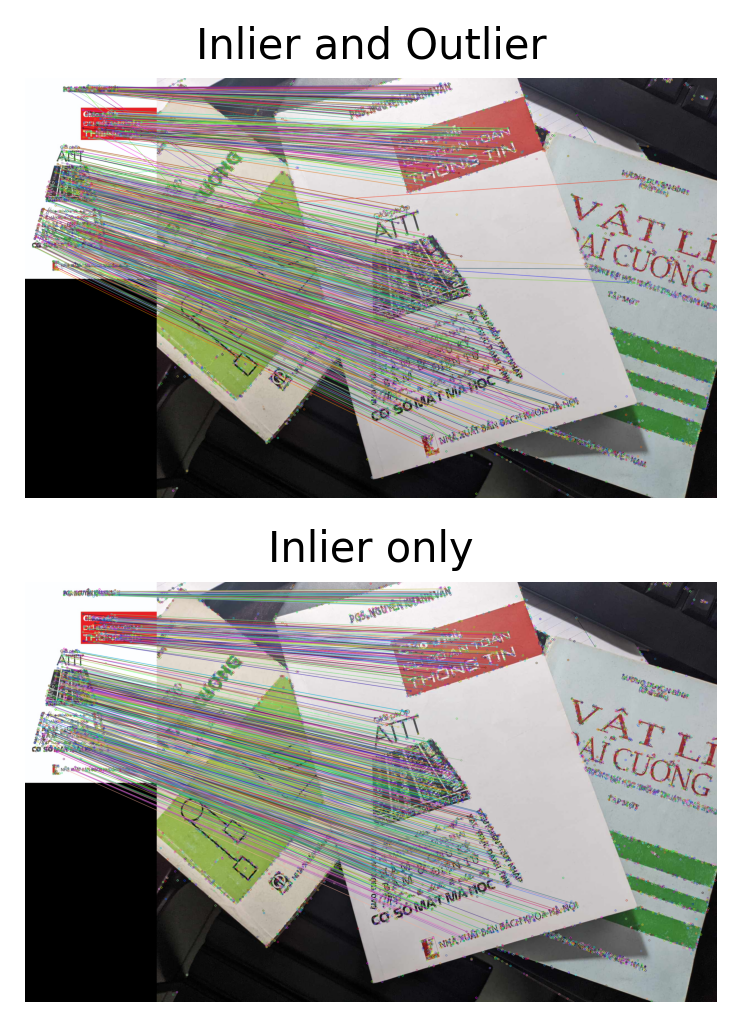

In [3]:
img1 = cv.imread('../images/cover.jpg') # query image
img2 = cv.imread('../images/books.jpg') # train image

sift = cv.SIFT_create() # khởi tạo lớp thuật toán SIFT
kp1, des1 = sift.detectAndCompute(img1, None) # phát hiện các đặc trưng, keypoints SIFT trong query image
kp2, des2 = sift.detectAndCompute(img2, None) # phát hiện các đặc trưng, keypoints SIFT trong train image

bf = cv.BFMatcher() # khởi tạo lớp thuật toán ghép cặp với metric mặc định NORM_L2
matches = bf.knnMatch(des1, des2, k=2) # mỗi query descriptor ghép với hai train descriptor gần nhất
                                       # trả về danh sách gồm các tuple, mỗi tuple gồm k DMatch tương ứng với k cặp ghép cho query descriptor

good = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good.append(m)

# vẽ các ghép cặp giữa hai ảnh
img3 = cv.drawMatches(img1, kp1, img2, kp2, good, None)

src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]) # xác định tập điểm x
dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]) # xác định tập điểm y

H, matchesMask = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 5.0) # truyền vào sai số epsilon bằng 5.0

H /= H[-1,-1]
print(H)

# matchesMask ứng với mask của inlier trong tập dữ liệu (src_pts, dst_pts)
img4 = cv.drawMatches(img1, kp1, img2, kp2, good, None, matchesMask=matchesMask.ravel())

plt.rcParams['figure.dpi'] = 250
plt.subplot(2, 1, 1)
plt.imshow(cv.cvtColor(img3, cv.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Inlier and Outlier")
plt.subplot(2, 1, 2)
plt.imshow(cv.cvtColor(img4, cv.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Inlier only")